In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
import keras 
import keras.layers as L

from collections import defaultdict
from itertools import count
from IPython.display import clear_output
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
from keras.optimizers import Adam

%matplotlib inline

Using TensorFlow backend.


In [4]:
image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = image_generator.flow_from_directory(
        'data/00_input/train/',
        target_size=(224, 224),
        batch_size=100,
        class_mode='sparse'
)


val_generator = image_generator.flow_from_directory(
        'data/00_input/val/',
        target_size=(224, 224),
        batch_size=50,
        class_mode='sparse'
)

Found 2000 images belonging to 50 classes.
Found 500 images belonging to 50 classes.


In [18]:
# model

num_classes = 50
xception = Xception()
for layer in xception.layers: # freeze layers
    layer.trainable = False
    
activation = xception.get_layer('block14_sepconv2_act').output
pool = L.GlobalMaxPooling2D()(activation)
dropout = L.Dropout(0.5)(pool)
dense = L.Dense(200, activation='relu')(dropout)
dense = L.Dense(num_classes, activation='softmax')(dense)
model = keras.models.Model(inputs=xception.inputs, outputs=dense)

In [5]:
model = keras.models.load_model('models/model3')
history = json.load(open('history3.json', 'r'))

In [6]:
def get_data_for_plot(data, num_dots=100, tail=0.1):
    tail = int(tail * num_dots)
    if len(data) < num_dots:
        plt_data = data
        plt_x = None
    else:
        plt_data = np.empty(num_dots)
        plt_data[-tail:] = data[-tail:]
        borders = np.array(np.round(np.linspace(0, len(data) - tail, num_dots - tail + 1)), dtype=np.int)
        for i in range(len(borders) - 1):
            plt_data[i] = np.mean(data[borders[i]:borders[i + 1]])
        plt_x = np.array([*borders[:-1]] + [*range(len(data) - tail, len(data))])
        plt_borders = np.array(np.round(np.linspace(0, len(borders)-1, 5)), dtype=np.int)
        plt_x = [*borders[plt_borders]] + []
        
    return dict(
        y=plt_data,
        xticks_labels = plt_x,
    )

def plot_one(**kwargs):
    plt.plot(kwargs.get('y'), label=kwargs.get('label'))
    #plt.xticks(ticks=range(len(kwargs.get('xticks_labels'))), labels=kwargs.get('xticks_labels'))
    plt.title(kwargs.get('title', ''))
    if 'label' in kwargs:
        plt.legend()


def plot(history):
    plt.figure(figsize=(16, 12))
    for what, num in zip(('entropy', 'accuracy'), (1, 2)):
        ax = plt.subplot(2, 1, num)
        ax.grid()
        for where in ('train', 'val'):
            plot_one(
                title=what, 
                label='{} {:0.3}'.format(where, history['_'.join([where, what])][-1]),
                **get_data_for_plot(history['_'.join([where, what])])
            )
    plt.show()
            
def train_model(model, train_generator, val_generator, history=None, n_iters=None):
    if history is None:
        history = defaultdict(list)    
    for (
        (images_train, targets_train), 
        (images_val, targets_val)
    ) in zip(train_generator, val_generator):
        try:
            entropy, accuracy = model.train_on_batch(images_train, targets_train)
            history['train_entropy'].append(float(entropy))
            history['train_accuracy'].append(float(accuracy))
            entropy, accuracy = model.test_on_batch(images_val, targets_val)
            history['val_entropy'].append(float(entropy))
            history['val_accuracy'].append(float(accuracy))

            if len(history['train_entropy']) % 10 == 0:
                print('Saving model')
                model.save('models/model3')
                json.dump(history, open('history3.json', 'w'))
            clear_output(True)
            plot(history)
            print('Iteration', len(history['train_entropy']))
            if n_iters is not None and len(history['train_entropy']) >= n_iters:
                break
        except KeyboardInterrupt:
            break
    print('Saving model')
    model.save('models/model3')
    return history

In [24]:
model.compile(
    optimizer=Adam(lr=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['sparse_categorical_accuracy']
)

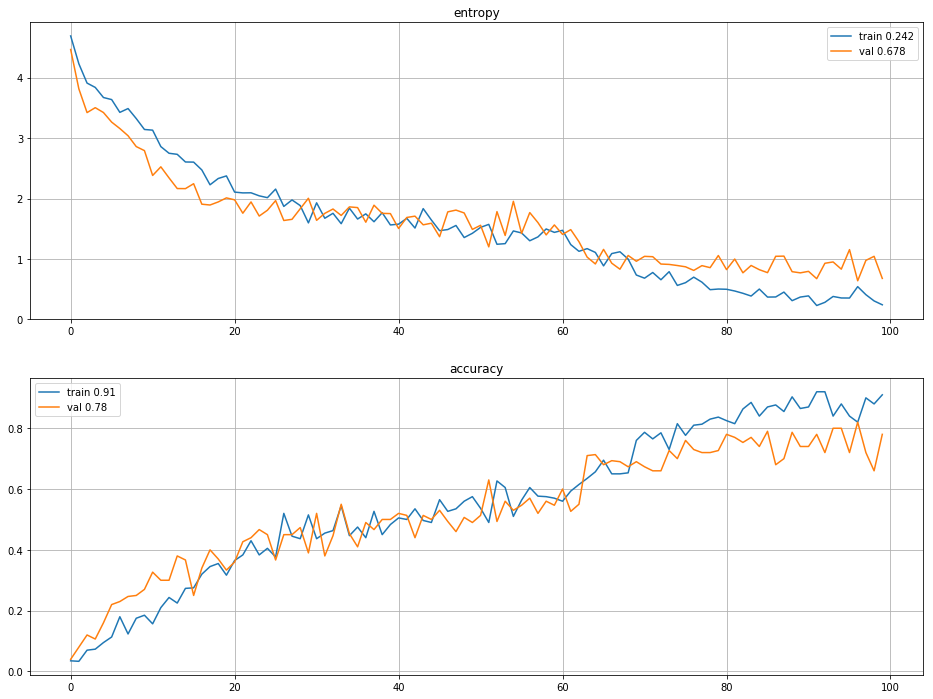

Iteration 230
Saving model


In [25]:
history = train_model(model, train_generator, val_generator, n_iters=150)

for layer in model.layers:
    layer.trainable = True
model.compile(
    optimizer=Adam(lr=0.0001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['sparse_categorical_accuracy']
)

history = train_model(model, train_generator, val_generator, history=history)

In [26]:
model.compile(
    optimizer=Adam(lr=0.00001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['sparse_categorical_accuracy']
)

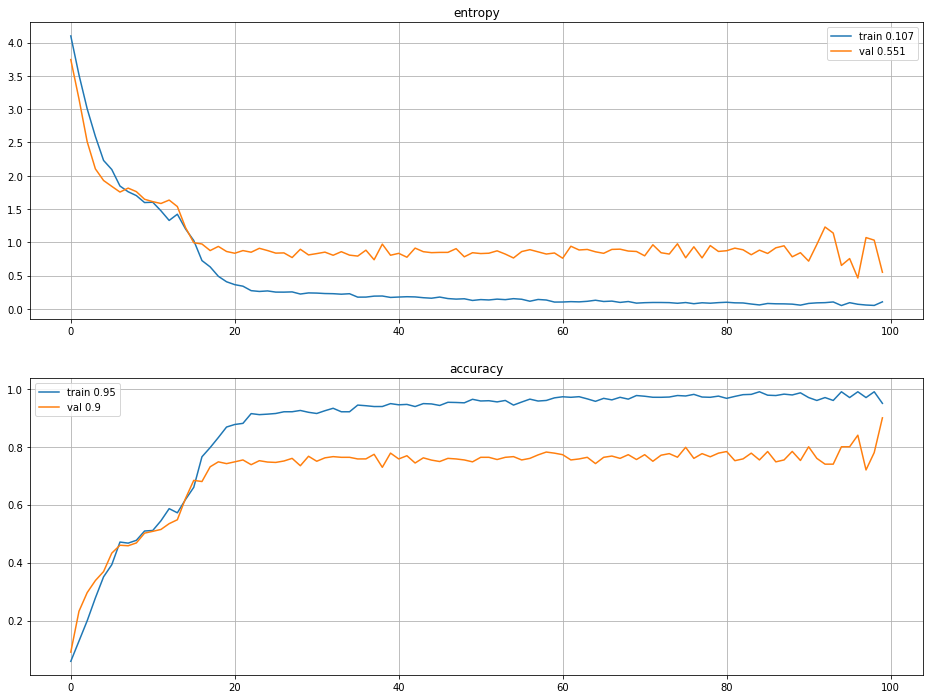

Iteration 963
Saving model


In [27]:
history = train_model(model, train_generator, val_generator, history=history)

In [9]:
model.evaluate_generator(val_generator, steps=10)

[0.82166508436203, 0.7599999964237213]

In [8]:
for layer in model.layers:
    layer.trainable = True

In [ ]:
from keras.preprocessing.image import 